In [ ]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings("ignore")

# 1. Unzip and Load Word Embeddings


## 1.1 Unzip Word Embeddings


In [ ]:
import bz2

In [155]:
with open("./embeddings/sgns.weibo.bigram", 'wb') as new_file, open("./embeddings/sgns.weibo.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

## 1.2 Load Word Embeddings


In [ ]:
from gensim.models import KeyedVectors

In [157]:
cn_model = KeyedVectors.load_word2vec_format('./embeddings/sgns.weibo.bigram', 
                                             binary=False,
                                             unicode_errors="ignore")

# 2. Corpus Preprocessing


In [158]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2.1 Read Raw Text
- **weibo**: DataFrame storing the blog posts and their corresponding labels.
- **content**: list storing the raw text strings.
- **label**: label, where 1 indicates non-rumor.


In [159]:
import pandas as pd

In [ ]:
weibo = pd.read_csv('./data/all_data.txt',sep='\t', names=['is_not_rumor','content'],encoding='utf-8')
weibo = weibo.dropna()
weibo.head()

,is_not_rumor,content
0,0,【小哥频道】赵本山涉黑，再次被抓，证据确凿。子虚大师卧底赵家堂口，冒生命危险，拍到黑帮内部拜...
1,1,2013年了，正式发表征婚帖：我在上海，年龄27岁，喜欢短发阳刚的朋友，我单身的时候喜欢和朋...
2,1,幸福就是重复。每天跟自己喜欢的人一起，通电话，旅行，重复一个承诺和梦想，听他第二十八次提起童...
3,0,朋友妈妈在公交捡到了个钱包，里面有两张身份证，驾驶证，和三张1月25号惠州到武昌的火车票，名...
4,0,【请记住：轮奸要第一个上！】李双江之子李天一涉嫌强奸罪被批捕。李的76人律师团领队、法律大学...


In [161]:
weibo.shape

(3387, 2)

In [ ]:
content = weibo.content.values.tolist()
label=weibo.is_not_rumor.values.tolist()

In [163]:
print (content[3:5])

['朋友妈妈在公交捡到了个钱包，里面有两张身份证，驾驶证，和三张1月25号惠州到武昌的火车票，名字分别是陈翠珍，高艳林，张馨元。春运期间，不知道失主花了多少功夫买这三张卧铺票，没了身份证如何回家过年，一定急疯了。转发举手之劳。 (联系:陈珉岩 13006609059请帮忙传递正能量', '【请记住：轮奸要第一个上！】李双江之子李天一涉嫌强奸罪被批捕。李的76人律师团领队、法律大学副校长张爱国教授对媒体表示，李天一因是第一个与被害女子发生关系，所以不构成轮奸罪，只是以判罚较轻的强奸罪批捕，这是律师团所有成员共同努力的结果。记住啊，轮奸要第一个上！（转）']


## 2.2 Perform Word Segmentation and Tokenization


### Process for Each Weibo Text (text)
1. Remove punctuation marks from each sample.
2. Use pkuseg for word segmentation, resulting in **cut_list**.
3. Remove stop words from **cut_list** to get **cut_list_clean**.
4. Index the words in **cut_list_clean** using the "chinese-word-vectors" pretrained model from Beijing Normal University and Renmin University DBIIR lab. This turns each text into a sequence of index numbers corresponding to words in the pretrained word embedding model.

Store the results for each text in **train_tokens**.


In [164]:
import pkuseg

In [ ]:

stopwords=pd.read_csv("./stopwords/stopwords.txt",index_col=False,sep="\t",quoting=3,names=['stopword'], encoding='utf-8')
stopwords = stopwords.stopword.values.tolist()

In [ ]:
seg = pkuseg.pkuseg(model_name='web')  

In [ ]:
train_tokens = []
for text in content:
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut_list = seg.cut(text)

    cut_list_clean=[]
    for word in cut_list:
        if word in stopwords:
            continue
        cut_list_clean.append(word)
    
    for i, word in enumerate(cut_list_clean): # enumerate()
        try:
            cut_list_clean[i] = cn_model.key_to_index[word]
        except KeyError:
            cut_list_clean[i] = 0
    train_tokens.append(cut_list_clean)

## 2.3 Index Length Normalization


Since the length of each comment is different, simply taking the longest comment and padding the others to the same length would waste computational resources. Therefore, a compromise length will be chosen to balance efficiency and effectiveness.

In [ ]:
num_tokens = [len(tokens) for tokens in train_tokens]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

58

### Padding and Truncating
Padding and truncating are techniques used to ensure that all text sequences have the same length:
- **Padding**: Adding zeros (or another placeholder) to the end of shorter sequences to match the desired length.
- **Truncating**: Cutting longer sequences to the desired length, ensuring consistency across all input sequences.


After converting the text to tokens (indices), the length of each token sequence is not equal. To facilitate model training, we need to standardize the length of the token sequences. We selected a `max_tokens` length that covers 95% of the training samples. 

Next, we perform padding and truncating. We generally use the `'pre'` method, which pads zeros at the beginning of the token sequence. According to some studies and practical findings, padding zeros at the end of the sequence can have a negative impact on the model's performance.

**Input**: `train_tokens` (a list of token sequences)  
**Output**: `train_pad` (a numpy array with padded and truncated sequences)

In [169]:
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

## 2.4 Prepare Embedding Matrix

- **Input Format**: The embedding matrix needs to have the dimensions of (num_words, embedding_dim), where `num_words` represents the number of words used in the model. This matrix will be used as the input to the model.
  
- **Pretrained Word Embeddings**: Instead of training the word embeddings, use pretrained word vectors from the "chinese-word-vectors" dataset provided by Beijing Normal University and Renmin University DBIIR lab researchers. The word vectors can be found at [Chinese-Word-Vectors GitHub](https://github.com/Embedding/Chinese-Word-Vectors). The embedding dimension in this pretrained model is 300, meaning each word is represented by a vector of length 300.

- **Vocabulary Size**: Only the top 50,000 most frequent words are selected. This is because the pretrained word vector model has 2.6 million words, and using all of them in a small classification problem would be computationally inefficient. For larger datasets, you can consider using a larger vocabulary size for classification tasks.

In [ ]:
num_words = 50000
embedding_dim=300

embedding_matrix = np.zeros((num_words, embedding_dim))

for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')

np.sum(cn_model[cn_model.index_to_key[333]] == embedding_matrix[333] )

300

In [ ]:
train_pad[train_pad>=num_words ] = 0

train_target = np.array(label)

# 3. Train Corpus


In [172]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from utils import Attention,convolution
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

## LSTM

In [174]:
model = Sequential()
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=32, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer=tf.keras.optimizers.legacy.Adam(lr=1e-3)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 58, 300)           15000000  
                                                                 
 bidirectional_12 (Bidirect  (None, 58, 128)           186880    
 ional)                                                          
                                                                 
 dropout_5 (Dropout)         (None, 58, 128)           0         
                                                                 
 bidirectional_13 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 64)              

## GRU


In [175]:
model1 = Sequential()
model1.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))
model1.add(Bidirectional(GRU(32)))
model1.add(Dense(6, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
optimizer=tf.keras.optimizers.legacy.Adam(lr=1e-3)
model1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 58, 300)           15000000  
                                                                 
 bidirectional_14 (Bidirect  (None, 64)                64128     
 ional)                                                          
                                                                 
 dense_26 (Dense)            (None, 6)                 390       
                                                                 
 dense_27 (Dense)            (None, 1)                 7         
                                                                 
Total params: 15064525 (57.47 MB)
Trainable params: 64525 (252.05 KB)
Non-trainable params: 15000000 (57.22 MB)
_________________________________________________________________


## CNN+LSTM+ATTENTION

In [176]:
model2 = Sequential()
model2.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))
model2.add(Conv1D(32,1,activation='relu'))
model2.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model2.add(Attention(return_sequences=True))
model2.add(LSTM(units=32, return_sequences=False))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
optimizer=tf.keras.optimizers.legacy.Adam(lr=1e-3)
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 58, 300)           15000000  
                                                                 
 conv1d_3 (Conv1D)           (None, 58, 32)            9632      
                                                                 
 bidirectional_15 (Bidirect  (None, 58, 128)           49664     
 ional)                                                          
                                                                 
 attention_3 (Attention)     (None, 58, 128)           186       
                                                                 
 lstm_15 (LSTM)              (None, 32)                20608     
                                                                 
 dense_28 (Dense)            (None, 64)                2112      
                                                     

## TextCNN

In [177]:
model3 = Sequential()
model3.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))
model3.add(Reshape((58,300, 1)))
model3.add(convolution())
model3.add(Flatten())
model3.add(Dense(10, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 58, 300)           15000000  
                                                                 
 reshape_3 (Reshape)         (None, 58, 300, 1)        0         
                                                                 
 model_3 (Functional)        (None, 1, 1, 192)         230592    
                                                                 
 flatten_3 (Flatten)         (None, 192)               0         
                                                                 
 dense_30 (Dense)            (None, 10)                1930      
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 dense_31 (Dense)            (None, 1)               

In [178]:
import os

In [ ]:

checkpoint_save_path="./checkpoint/rumor_LSTM.ckpt"
if os.path.exists(checkpoint_save_path+'.index'):
    print('----------load the model----------')
    model.load_weights(checkpoint_save_path)

In [ ]:

checkpoint = ModelCheckpoint(filepath=checkpoint_save_path, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [ ]:

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

callbacks = [
    # earlystopping, 
#    checkpoint,
    lr_reduction
]

In [182]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

========================model1===================

In [ ]:

checkpoint_save_path1="./checkpoint/rumor_GRU.ckpt"
if os.path.exists(checkpoint_save_path1+'.index'):
    print('----------load the model----------')
    model1.load_weights(checkpoint_save_path1)

In [ ]:

checkpoint1 = ModelCheckpoint(filepath=checkpoint_save_path1, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [185]:
model1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

========================model2===================

In [ ]:

checkpoint_save_path2="./checkpoint/rumor_CNN_LSTM.ckpt"
if os.path.exists(checkpoint_save_path2+'.index'):
    print('----------load the model----------')
    model2.load_weights(checkpoint_save_path2)

In [ ]:

checkpoint2 = ModelCheckpoint(filepath=checkpoint_save_path2, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [188]:
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

========================model3===================

In [ ]:

checkpoint_save_path3="./checkpoint/rumor_TextCNN.ckpt"
if os.path.exists(checkpoint_save_path3+'.index'):
    print('----------load the model----------')
    model3.load_weights(checkpoint_save_path3)

In [ ]:

checkpoint3 = ModelCheckpoint(filepath=checkpoint_save_path3, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [191]:
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [192]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    acc = history.history.get('accuracy') or history.history.get('acc')  
    val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/12
22/22 [==============================] - 8s 204ms/step - loss: 0.6304 - accuracy: 0.6384 - val_loss: 0.5026 - val_accuracy: 0.7574
Epoch 2/12
22/22 [==============================] - 4s 165ms/step - loss: 0.4563 - accuracy: 0.7966 - val_loss: 0.4506 - val_accuracy: 0.7803
Epoch 3/12
22/22 [==============================] - 4s 171ms/step - loss: 0.3958 - accuracy: 0.8276 - val_loss: 0.4394 - val_accuracy: 0.7836
Epoch 4/12
22/22 [==============================] - 4s 169ms/step - loss: 0.3327 - accuracy: 0.8542 - val_loss: 0.3886 - val_accuracy: 0.8393
Epoch 5/12
22/22 [==============================] - 4s 172ms/step - loss: 0.2899 - accuracy: 0.8801 - val_loss: 0.3900 - val_accuracy: 0.8393
Epoch 6/12
22/22 [==============================] - 4s 170ms/step - loss: 0.2499 - accuracy: 0.9048 - val_loss: 0.4530 - val_accuracy: 0.8131
Epoch 7/12
22/22 [==============================] - 4s 172ms/step - loss: 0.2076 - accuracy: 0.9220 - val_loss: 0.3977 - val_accuracy: 0.8459
Epoch 

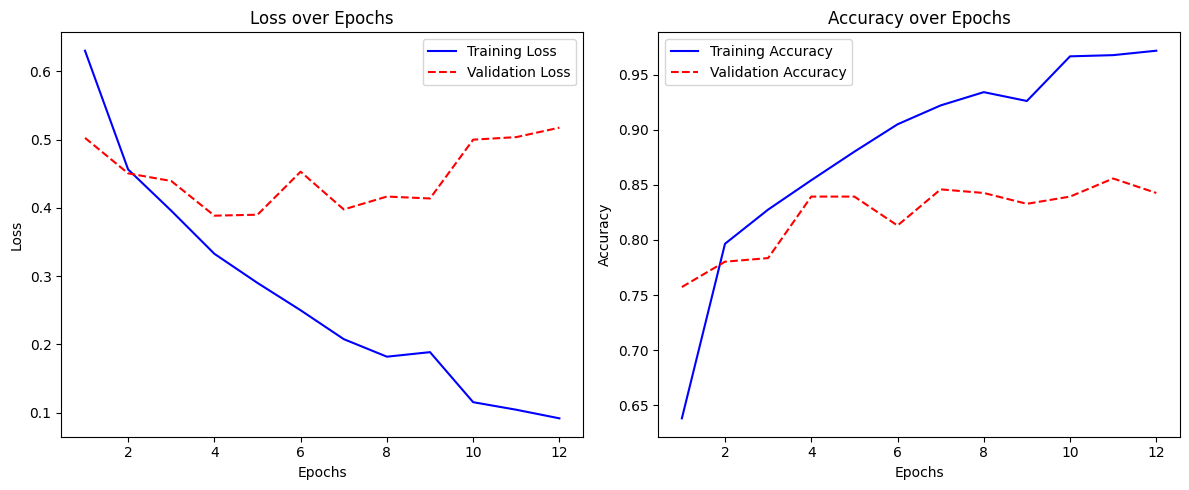

In [193]:
history1 = model.fit(X_train, y_train,validation_split=0.1,epochs=12,batch_size=128)
plot_training_history(history1)

======================model1===========================

Epoch 1/15
22/22 [==============================] - 1s 44ms/step - loss: 0.6568 - accuracy: 0.5771 - val_loss: 0.5572 - val_accuracy: 0.7082 - lr: 0.0010
Epoch 2/15
22/22 [==============================] - 1s 39ms/step - loss: 0.5256 - accuracy: 0.6861 - val_loss: 0.4582 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 3/15
22/22 [==============================] - 1s 39ms/step - loss: 0.4189 - accuracy: 0.7834 - val_loss: 0.3911 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 4/15
22/22 [==============================] - 1s 39ms/step - loss: 0.3467 - accuracy: 0.8352 - val_loss: 0.3537 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 5/15
22/22 [==============================] - 1s 39ms/step - loss: 0.2801 - accuracy: 0.8914 - val_loss: 0.3399 - val_accuracy: 0.8459 - lr: 0.0010
Epoch 6/15
21/22 [===========================>..] - ETA: 0s - loss: 0.2230 - accuracy: 0.9148
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
22/22 [==============================] - 1s 40ms/step - los

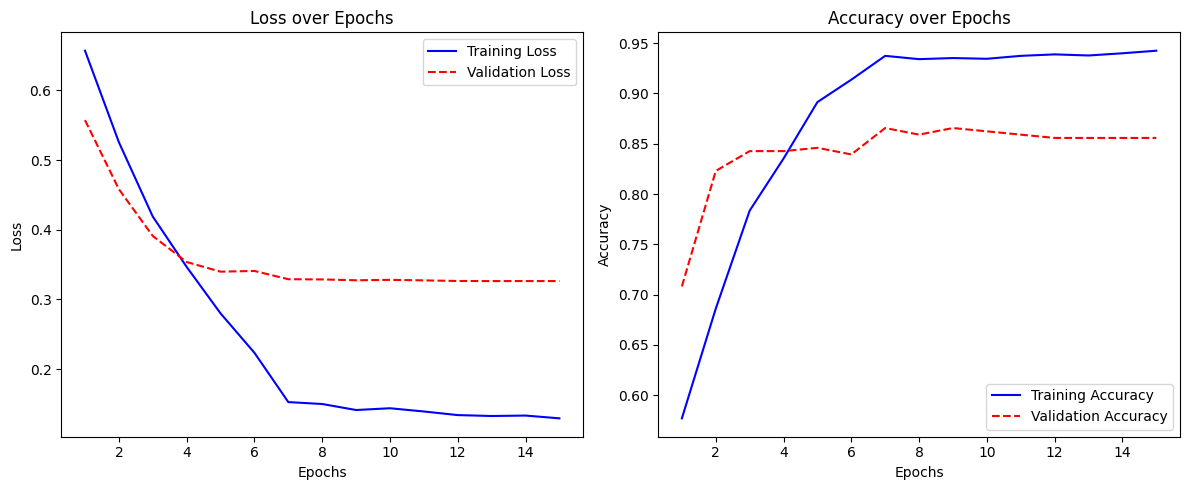

In [194]:
history2 = model3.fit(X_train, y_train,validation_split=0.1,epochs=15,batch_size=128,callbacks=callbacks)
plot_training_history(history2)

Epoch 1/20
22/22 [==============================] - 5s 115ms/step - loss: 0.6932 - accuracy: 0.4594 - val_loss: 0.6932 - val_accuracy: 0.4492 - lr: 1.0000e-07
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4604
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
22/22 [==============================] - 2s 85ms/step - loss: 0.6932 - accuracy: 0.4604 - val_loss: 0.6932 - val_accuracy: 0.4492 - lr: 1.0000e-07
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4615
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-08.
22/22 [==============================] - 2s 87ms/step - loss: 0.6932 - accuracy: 0.4615 - val_loss: 0.6932 - val_accuracy: 0.4492 - lr: 1.0000e-08
Epoch 4/20
22/22 [==============================] - 2s 87ms/step - loss: 0.6932 - accuracy: 0.4612 - val_loss: 0.6932 - val_accuracy: 0.4426 - lr: 1.0000e-08
Epoch 5/20
22/22 [==============================] - 2s 88ms/step 

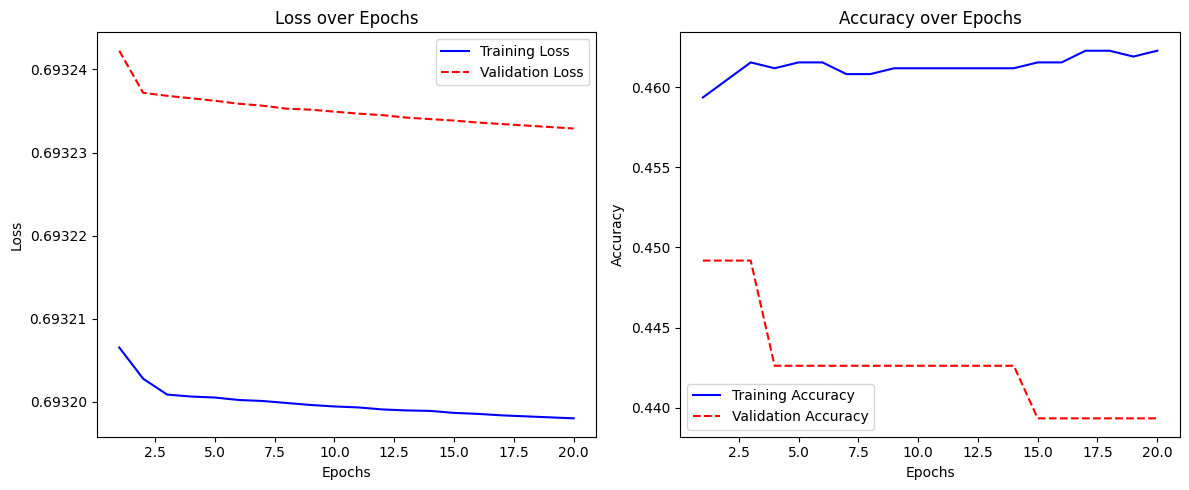

In [195]:
history3 = model2.fit(X_train, y_train,validation_split=0.1,epochs=20,batch_size=128,callbacks=callbacks)
plot_training_history(history3)

Epoch 1/20
22/22 [==============================] - 1s 41ms/step - loss: 0.1322 - accuracy: 0.9457 - val_loss: 0.3264 - val_accuracy: 0.8557 - lr: 1.0000e-08
Epoch 2/20
22/22 [==============================] - 1s 40ms/step - loss: 0.1360 - accuracy: 0.9417 - val_loss: 0.3264 - val_accuracy: 0.8557 - lr: 1.0000e-08
Epoch 3/20
22/22 [==============================] - 1s 40ms/step - loss: 0.1263 - accuracy: 0.9457 - val_loss: 0.3264 - val_accuracy: 0.8557 - lr: 1.0000e-08
Epoch 4/20
22/22 [==============================] - 1s 39ms/step - loss: 0.1279 - accuracy: 0.9457 - val_loss: 0.3264 - val_accuracy: 0.8557 - lr: 1.0000e-08
Epoch 5/20
22/22 [==============================] - 1s 41ms/step - loss: 0.1273 - accuracy: 0.9479 - val_loss: 0.3264 - val_accuracy: 0.8557 - lr: 1.0000e-08
Epoch 6/20
22/22 [==============================] - 1s 40ms/step - loss: 0.1356 - accuracy: 0.9431 - val_loss: 0.3264 - val_accuracy: 0.8557 - lr: 1.0000e-08
Epoch 7/20
22/22 [==============================] - 

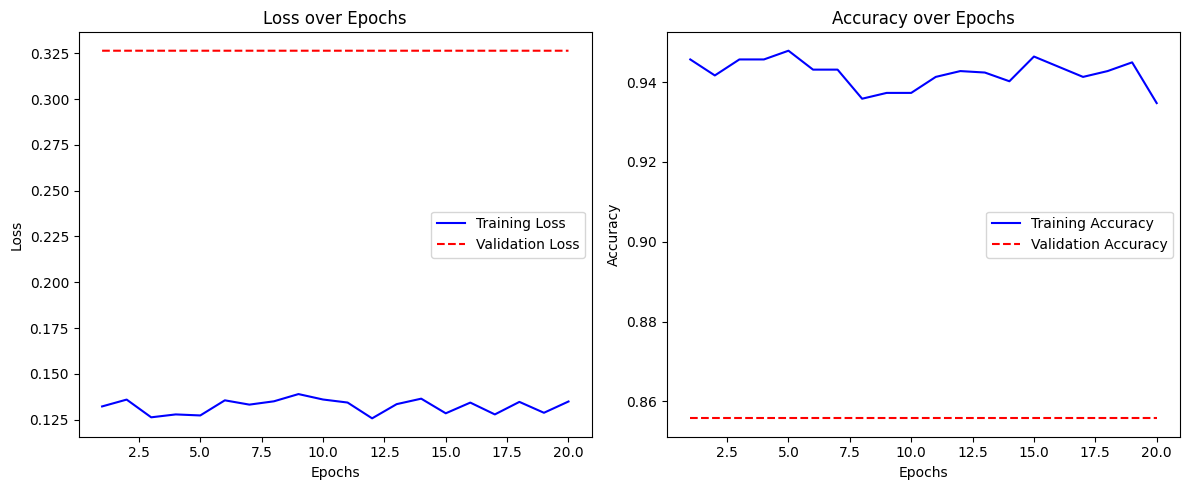

In [196]:
history4 = model3.fit(X_train, y_train,validation_split=0.1,epochs=20,batch_size=128,callbacks=callbacks)
plot_training_history(history4)

In [ ]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))      # LSTM

11/11 [==============================] - 0s 35ms/step - loss: 0.4079 - accuracy: 0.8555
Accuracy:85.55%


In [200]:
result = model3.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))      # TextCNN

11/11 [==============================] - 0s 6ms/step - loss: 0.3093 - accuracy: 0.8820
Accuracy:88.20%
